This notebook contains:
- Loading Sentinel-2 data and WorldCover data, and saving to a Zarr file using Dask
- Model and dataset definitions for an 11-class Prithvi based classification model based on the WorldCover dataset
- A training function using DDP and `dask_pytorch_ddp` to finetune Prithvi
- Various tests for each component

Most of the cells are fairly self-contained. I plan to clean up the implementation so it flows more cohesively and remove any repeated code.

Note:
- The dataset is relatively small, so I can test it easily

Next steps (in rough order):
- Create demo-friendly visualisations
- Clean up the notebook to make it more reusable and Argo-friendly
- Decide whether to expand the dataset as limited training is fairly poor
- Clean-up recently refractored code
- Research efficiency improvements in both data loading and training for next notebook
- Investigate skipping the S3 save step and training directly from the source data

In [1]:
# Common imports and settings
import os, sys, re, io
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import numpy as np
# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
import s3fs
import boto3

# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [3]:
try:
    import git
    repo_root = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
    repo2 = repo_root / "easi_tools/dask_helpers"
except (ImportError, git.InvalidGitRepositoryError):
    repo2 = Path.home() / 'easi-notebooks/easi_tools/dask_helpers'
    if not repo2.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo2 not in sys.path:
    sys.path.append(str(repo2))    # Add the local path to `easi-notebooks` to python
#print(repo2)
from label_mappers import LabelMapper, WorldCoverLabelMapper
from training_helpers import train_one_epoch, evaluate, SegmentationTask, wrap_model_with_fsdp, train_one_epoch_log

print("Dask EASI tools loaded successfully")

Dask EASI tools loaded successfully


In [4]:
import torch
from terratorch.registry import BACKBONE_REGISTRY

import time
from dask.distributed import wait
from collections import Counter
from dask_pytorch_ddp import dispatch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import torch.optim as optim
from datetime import datetime#, timedelta
import json
import torch.distributed as dist
import terratorch
from contextlib import nullcontext
from torch.cuda.amp import autocast, GradScaler
from s3torchconnector import S3Checkpoint

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP


print("DL libraries imported successfully")

DL libraries imported successfully


# Dask Setup

In [5]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify
options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 1
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

Creating new cluster...
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.7037f646a8d342b4b845cf1ca6e5902e/status


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/env/lib/python3.12/site-packages/tornado/iostream.py", line 1363, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/uv/python-installs/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/ssl.py", line 1319, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate (_ssl.c:1010)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/uv/python-installs/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/env/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 208, in _handle_events
    handler_func(fileobj, events)
  File "/env/lib/python3.12/site-packages/tornado/iostream.py", line 691, in _handle_events
    sel

In [12]:
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

This implimentation uses `DDP` and `dask-pytorch-ddp`, if `dask-pytorch-ddp` is not on your worker image you need to install them.

In [6]:

print("Installing dask-pytorch-ddp on all workers...")
client.run(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

# 2. Install on the Scheduler (This is the crucial missing step)
print("Installing dask-pytorch-ddp on the Scheduler...")
client.run_on_scheduler(lambda: exec("import sys; import subprocess; subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'dask-pytorch-ddp'])"))

print("Installation initiated on both Scheduler and Workers. Now retry the DDP run.")
#client.restart()

Installing dask-pytorch-ddp on all workers...
Installing dask-pytorch-ddp on the Scheduler...
Installation initiated on both Scheduler and Workers. Now retry the DDP run.


# Getting your dataset
We will use the s3 bucket spcified linked to my EASI acount for storing the data.

In [7]:
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
base_prefix = f"{userid}/{project_name}"
s3_base = f"s3://{bucket}/{base_prefix}"
log_dir = "logs/"
output_dir = "models/"
dataset_name = "training_dataset_v3.zarr"
s3_path_final = f"s3://{bucket}/{base_prefix}/training_dataset_v3.zarr"

Successfully found configuration for deployment "csiro"


# Fine Tuning Setup
We want to define:
- The model we will be fine tuning
- The dataset that will read from the s3 Bucket and feed data to the model during training
Both the model and dataset will usually depend on your specific use case but some genera things:
- Make sure to freeze tha backbone of the model
- Make sure the forward pass fits you dataset dims or vice versa
- Do any transformations you need within the dataset

For this Prithvi Model I have:
- Loadeed in the bakcbone
- Freeze the weights
- Added a decoader head
- A robust forward pass that goes through the backbone and to the new head

In [8]:
class PrithviBackbone(nn.Module):
    def __init__(self, embed_dim=1024, freeze=True, num_frames=3):
        super().__init__()
        self.encoder = BACKBONE_REGISTRY.build(
            "prithvi_eo_v2_300",
            pretrained=True,
            num_frames=num_frames,
        )
        if freeze:
            for p in self.encoder.parameters():
                p.requires_grad = False
        self.embed_dim = embed_dim

    def forward(self, x):
        # x: (B, C, T, H, W)
        assert x.dim() == 5
        B, C, T, H, W = x.shape

        features = self.encoder(x)
        if isinstance(features, (list, tuple)):
            features = features[-1]  # (B, L, C2)

        if features.dim() == 3:
            if features.shape[1] % (T * (H // 16) * (W // 16)) == 1:
                features = features[:, 1:, :]

            B2, L, C2 = features.shape
            t_patches = T
            h_patches = H // 16
            w_patches = W // 16
            assert L == t_patches * h_patches * w_patches

            features = features.view(B2, t_patches, h_patches, w_patches, C2)
            features = features.mean(dim=1)            # (B, H_p, W_p, C2)
            features = features.permute(0, 3, 1, 2)    # (B, C2, H_p, W_p)

        return features, (H, W)  # 2D feature map + original spatial size



class SegmentationHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(128, num_classes, kernel_size=1),
        )

    def forward(self, features, orig_hw):
        H, W = orig_hw
        logits = self.decode(features)
        logits = nn.functional.interpolate(
            logits, size=(H, W), mode="bilinear", align_corners=False
        )
        return logits



class PrithviSegmentation(nn.Module):
    def __init__(self, num_classes=11, freeze_backbone=True):
        super().__init__()
        self.backbone = PrithviBackbone(embed_dim=1024, freeze=freeze_backbone)
        self.head = SegmentationHead(in_channels=1024, num_classes=num_classes)

    def forward(self, x):
        features, orig_hw = self.backbone(x)
        logits = self.head(features, orig_hw)
        return logits

### Dataset
For this dataset we:
- Map the world Cover outputs to nicer class values
- Filter out any invalid values
- Convert to tensors

To help generalise the dataset, all datasets should return a dictionary.

In [9]:
class WorldCoverZarrDataset(torch.utils.data.Dataset):
    def __init__(self, zarr_path, patch_size=224, num_classes=11,
                 label_mapper: LabelMapper | None = None,
                 transform=None, target_transform=None):
        self.ds = xr.open_zarr(zarr_path, consolidated=True)
        self.n_samples = self.ds.sizes["sample"]
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.transform = transform
        self.target_transform = target_transform
        self.label_mapper = label_mapper or WorldCoverLabelMapper(num_classes=num_classes)
 
    def __len__(self):
        return self.n_samples
        
    def __getitem__(self, idx):
        sample = self.ds.isel(sample=idx)
        x = sample["features"].values   # (band, time, y, x)
        y_raw = sample["labels"].values # (y, x), floats with WC codes

        y = self.label_mapper.map(y_raw)

        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).long()

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return {
            "inputs": x,
            "labels": y,
            "meta": {"index": idx},
        }


# Fine Tuning
In order to make this interchangeable with other problems, we will use a "Task" template and then fill it out with our specific needs.

Being a small dataset may be worth making sure we have an even spread of the data.

In [10]:
def compute_class_weights(dataset, num_classes):
    """
    Estimate per-class weights from the training dataset.
    Ignores label 255 (ignore_index).
    """
    counts = Counter()
    for i in range(len(dataset)):
        sample = dataset[i]
        labels = sample["labels"]           # (H, W) torch.long

        labels_np = labels.numpy().ravel()
        labels_np = labels_np[labels_np != 255]
        counts.update(labels_np.tolist())

    weights = np.zeros(num_classes, dtype=np.float32)
    for c in range(num_classes):
        cnt = counts.get(c, 0)
        weights[c] = 1.0 / max(cnt, 1)

    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32)

Training has been broken up into steps so it is easy to replace with differnt model, tasks, etc...
We have:
- `to_device` and `wrap_model_with_fsdp` which applys the DDP libary, gets the optimiser and sends it to the workers
- `train_one_epoch` which handles the work of one full epoch: calculating loss and returning values in a nice format
- `evaluate` similar thing to the one_epoch function just handles the evaluation
- `train` which is the main training function
  - Handles setup
  - Splits the dataset into a train and validation dataset
  - Runs the epochs
  - Saves the logs of each epoch and the final model weights 

In [11]:
def train(
        zarr_path,
        s3_bucket,
        output_dir,
        log_dir,
        num_epochs,
        batch_size,
        learning_rate,
        num_classes,
        base_prefix="",
        checkpoint_file=None,
        patch_size=224,
        val_fraction=0.2,
        split_seed=42,
        shuffle_split=True,
        lr_step_size=5,
        lr_gamma=0.1,
        use_scheduler=True,
    ):

    if dist.is_available() and dist.is_initialized():
        worker_rank = int(dist.get_rank())
    else:
        worker_rank = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---- Dataset + train/val split ----
    full_ds = WorldCoverZarrDataset(zarr_path, patch_size=patch_size,
                                    num_classes=num_classes)

    indices = np.arange(len(full_ds))
    train_idx, val_idx = train_test_split(
        indices, test_size=val_fraction, random_state=split_seed,
        shuffle=shuffle_split
    )

    train_ds = Subset(full_ds, train_idx)
    val_ds = Subset(full_ds, val_idx)

    sampler_train = DistributedSampler(train_ds, shuffle=True)
    sampler_val = DistributedSampler(val_ds, shuffle=False)

    traingen = DataLoader(
        train_ds, batch_size=batch_size, sampler=sampler_train, shuffle=False
    )
    valgen = DataLoader(
        val_ds, batch_size=batch_size, sampler=sampler_val, shuffle=False
    )

    # ---- Build model and task ----
    base_model = PrithviSegmentation(num_classes=num_classes).to(device)

    # FSDP + optimizer kept in separate helper
    model, optimizer = wrap_model_with_fsdp(base_model, lr=learning_rate)
    model_without_ddp = model.module

    if use_scheduler:
        scheduler = StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)
    else:
        scheduler = None

    class_weights = compute_class_weights(train_ds, num_classes).to(device)
    task = SegmentationTask(num_classes=num_classes,
                            class_weights=class_weights)

    start_epoch = 0
    val_loss_min = np.Inf

    # ---- Optional checkpoint restore ----
    if checkpoint_file:
        ckpt_key = f"{base_prefix}/{checkpoint_file}" if base_prefix else checkpoint_file
        checkpoint_connection = S3Checkpoint(region='ap-southeast-2')
        with checkpoint_connection.reader(f"s3://{s3_bucket}/{ckpt_key}") as reader:
            checkpoint = torch.load(reader)
        model_without_ddp.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        val_loss_min = checkpoint['val_loss_min']

    # ---- Epoch loop (reuses generic functions) ----
    for epoch in range(start_epoch, num_epochs):
        sampler_train.set_epoch(epoch)
        sampler_val.set_epoch(epoch)

        train_stats = train_one_epoch(
            model, optimizer, scheduler, task, traingen, device
        )
        val_stats = evaluate(
            model, task, valgen, device
        )

        train_loss = train_stats["loss"]
        train_accuracy = train_stats["accuracy"]
        val_loss = val_stats["loss"]
        val_accuracy = val_stats["accuracy"]

        log = {
            "worker_rank": worker_rank,
            "epoch": epoch,
            "start_time": datetime.now().isoformat(),
            "lr": float(optimizer.param_groups[0]["lr"]),
            "train_loss": float(train_loss),
            "train_accuracy": float(train_accuracy),
            "val_loss": float(val_loss),
            "val_accuracy": float(val_accuracy),
            "end_time_val": datetime.now().isoformat(),
        }

        dist.barrier()
        if worker_rank == 0:
            log_key = f"{base_prefix}/{log_dir}/log_epoch_{epoch}.json"
            boto3.client("s3").put_object(
                Body=json.dumps(log),
                Bucket=s3_bucket,
                Key=log_key,
            )
            if val_loss < val_loss_min:
                val_loss_min = val_loss
                output_key = f"{base_prefix}/{output_dir}/model_{epoch}.pth" if base_prefix else f"{output_dir}/model_{epoch}.pth"
                checkpoint_connection = S3Checkpoint(region='ap-southeast-2')
                checkpoint = {
                    "model": model_without_ddp.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "val_loss_min": val_loss_min,
                }
                with checkpoint_connection.writer(f"s3://{s3_bucket}/{output_key}") as writer:
                    torch.save(checkpoint, writer)

    return

### Sending to workers
Specify your variables and then send it to the workers

In [14]:
num_epochs = 2
batch_size = 8
learning_rate = 0.001
num_classes = 11

client.restart()
client.wait_for_workers(NUM_WORKERS)
# Make sure the scheduler's view is used
sched_identity = client.run_on_scheduler(lambda dask_scheduler: dask_scheduler.identity())
_real_scheduler_info = client.scheduler_info
client.scheduler_info = lambda: sched_identity
# Use the repo2 path you defined earlier to locate the files
helpers_dir = repo2 

# Upload files using the absolute path
client.upload_file(str(helpers_dir / "training_helpers.py"))
client.upload_file(str(helpers_dir / "label_mappers.py"))

t0 = time.time()
futs = dispatch.run(
    client,
    train,
    zarr_path=s3_path_final,
    s3_bucket=bucket,
    output_dir=output_dir,
    log_dir=log_dir,
    base_prefix=base_prefix,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_classes=num_classes,
)

wait(futs)
t1 = time.time()
print("Done Training")
print(f"Total training time: {t1 - t0:.2f} s")

Done Training
Total training time: 599.63 s


# Results
Basic skeleton of what evaluation might look like. Still need to clean it up and add test dataset code etc...

In [15]:
zarr_path = f"s3://{bucket}/{userid}/{project_name}/{dataset_name}"
log_dir = f"{userid}/{project_name}/logs/"
output_dir = f"{userid}/{project_name}/models/"

In [16]:
s3 = boto3.client("s3")
log_prefix = f"{log_dir}log_epoch_"

resp = s3.list_objects_v2(Bucket=bucket, Prefix=log_prefix)
if "Contents" not in resp:
    print("No log files found under", log_prefix)
else:
    print("Found log files:")
    for o in resp["Contents"]:
        print(" ", o["Key"])

    # Load the last (highest epoch) log
    last_obj = sorted(resp["Contents"], key=lambda x: x["Key"])[-1]
    body = s3.get_object(Bucket=bucket, Key=last_obj["Key"])["Body"].read()
    log = json.loads(body.decode("utf-8"))
    print("Latest epoch log:")
    print("  epoch:", log.get("epoch"))
    print("  train_loss:", log.get("train_loss"))
    print("  val_loss:", log.get("val_loss"))
    print("  train_accuracy:", log.get("train_accuracy"))
    print("  val_accuracy:", log.get("val_accuracy"))


No log files found under AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/logs/log_epoch_


In [ ]:
# Clean up
fs = s3fs.S3FileSystem(anon=False)
log_prefix = f"{log_dir}log_epoch_"
# tmp_prefix should look like: "s3://bucket/userid/project_name/tmp"
print("Deleting temporary region stores under:", log_prefix)
fs.rm(log_prefix, recursive=True)

Successfully found configuration for deployment "csiro"
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[5.282830595970154, 1.3203741312026978, 1.1832569688558578, 1.2578036785125732, 1.1914577186107635, 1.1020104587078094, 1.1270178705453873, 1.1372428387403488, 1.1268170177936554, 1.123619794845581, 1.122630774974823, 1.1220800578594208, 1.1216024458408356, 1.1211284548044205, 1.1206950843334198, 1.1206349730491638, 1.12057925760746, 1.120524674654007, 1.120473489165306, 1.120413988828659]
[0.14797039421237246, 0.5006869569116709, 0.5392275440449618, 0.43394376793686223, 0.49806805046237246, 0.5334821428571428, 0.5031576351243623, 0.49048785774075254, 0.4958888462611607, 0.4953544772401148, 0.4950511698820153, 0.49486432756696425, 0.49468184490593115, 0.4944794323979592, 0.49431314273756377, 0.4942782655054209, 0.4942658093510842, 0.49425273038903067, 0.4942315549266582, 0.49422159000318877]


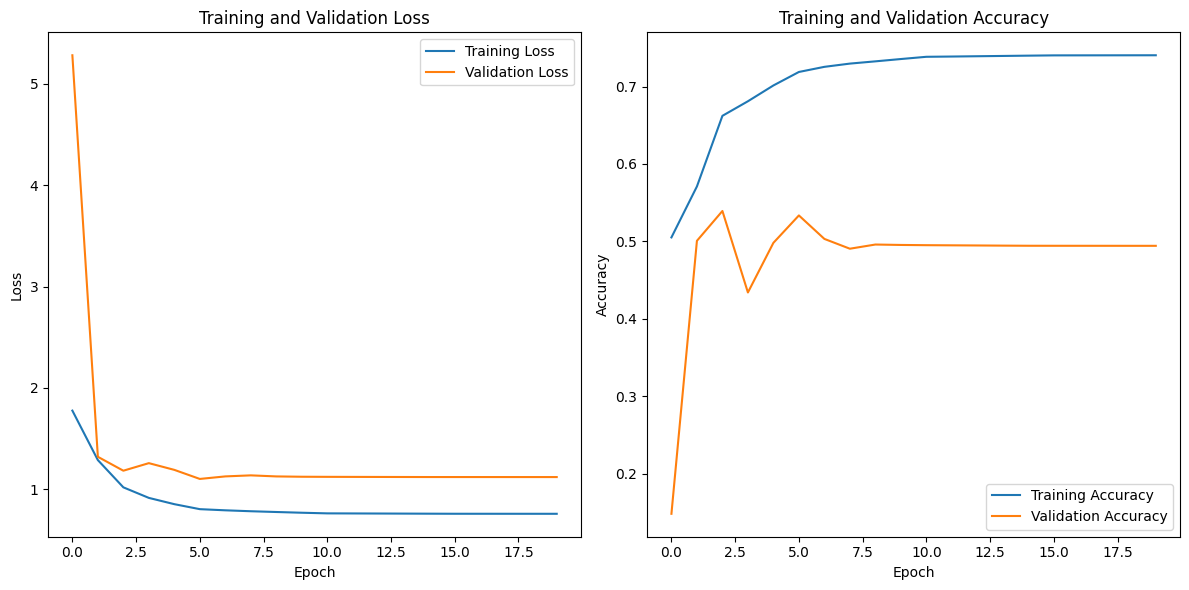

In [33]:
# Your configuration
easi = EasiDefaults()
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
log_dir = f"{userid}/{project_name}/logs/"
bucket_name = easi.scratch
log_prefix = f"{log_dir}log_epoch_"

s3 = boto3.client("s3")
resp = s3.list_objects_v2(Bucket=bucket, Prefix=log_prefix)

if "Contents" not in resp:
    print("No log files found under", log_prefix)
else:
    # Collect all log data
    logs = []
    for obj in resp["Contents"]:
        body = s3.get_object(Bucket=bucket, Key=obj["Key"])["Body"].read()
        log = json.loads(body.decode("utf-8"))
        logs.append(log)

    # Sort by epoch
    logs = sorted(logs, key=lambda x: x["epoch"])

    # Extract metrics
    epochs = [log["epoch"] for log in logs]
    print(epochs)
    train_losses = [log["train_loss"] for log in logs]
    val_losses = [log["val_loss"] for log in logs]
    print(val_losses)
    train_accuracies = [log["train_accuracy"] for log in logs]
    val_accuracies = [log["val_accuracy"] for log in logs]
    print(val_accuracies)
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


In [ ]:
# Your configuration
output_dir = f"{userid}/{project_name}"  # Your model output directory

s3 = boto3.client("s3")

# List all objects in the output directory
resp = s3.list_objects_v2(Bucket=bucket, Prefix=output_dir)

if "Contents" not in resp:
    print("No files found in", output_dir)
else:
    print("Files in", output_dir + ":")
    for obj in resp["Contents"]:
        print("  ", obj["Key"])


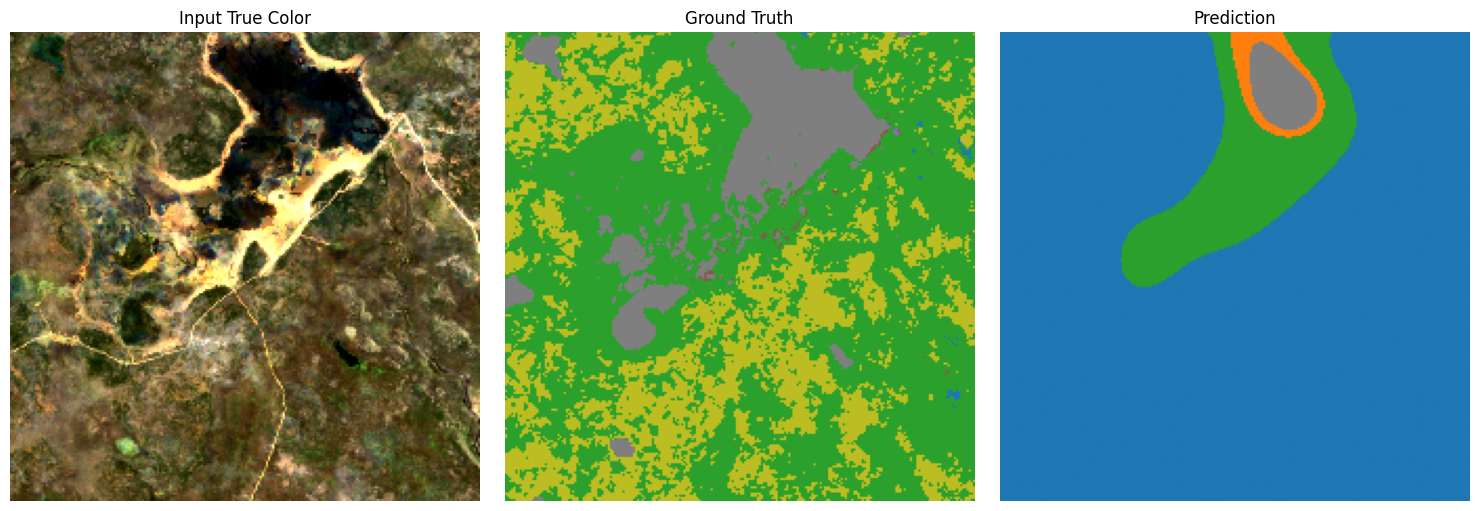

In [69]:
def get_rgb_for_sample(sample_features_da, bands_list):
    # sample_features_da dims: ('time','band','y','x') or ('band','time','y','x')
    if sample_features_da.dims[0] == "band":
        sample_features_da = sample_features_da.transpose("time", "band", "y", "x")

    stack = []
    for b in bands_list:
        band_data = sample_features_da.sel(band=b)      # (time, y, x)
        stack.append(band_data)

    img = xr.concat(stack, dim="color").values.astype("float32")   # (color, time, y, x)
    img = img / 10000.0
    img = np.nan_to_num(img, nan=0.0)
    img = np.transpose(img, (1, 2, 3, 0))   # (T, H, W, C)

    if img.max() == 0:
        return None

    for t in range(img.shape[0]):
        ts = img[t]
        valid = ts[ts > 0]
        if valid.size > 0:
            p2, p98 = np.percentile(valid, (2, 98))
            if p98 > p2:
                img[t] = (ts - p2) / (p98 - p2)

    img = np.clip(img, 0, 1)
    return img[0]   # first time step (H, W, C)

# 1. load checkpoint
def load_checkpoint_from_s3(bucket, key):
    s3 = boto3.client("s3")
    body = s3.get_object(Bucket=bucket, Key=key)["Body"].read()
    return torch.load(io.BytesIO(body), map_location="cpu")

#TODO Automate
# COPIED from above output
checkpoint_key = ""
ckpt = load_checkpoint_from_s3(bucket, checkpoint_key)

# 2. model
model = PrithviSegmentation(num_classes=11)
model.load_state_dict(ckpt["model"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 3. dataset sample for prediction (tensor)
val_ds = WorldCoverZarrDataset(zarr_path, patch_size=224, num_classes=11)
sample_idx = 5
sample_input, sample_label = val_ds[sample_idx]        # (C,T,H,W), (H,W)
sample_input = sample_input.unsqueeze(0).to(device)    # (1,C,T,H,W)

with torch.no_grad():
    output = model(sample_input)
    pred = output.argmax(dim=1).cpu().numpy()[0]

# 4. same sample from Zarr for RGB
fs = s3fs.S3FileSystem()
store = s3fs.S3Map(root=zarr_path, s3=fs, check=False)
ds = xr.open_dataset(store, engine="zarr", chunks={})
sample_features_da = ds["features"].isel(sample=sample_idx).compute()   # (time, band, y, x)

rgb_img = get_rgb_for_sample(sample_features_da, ["red", "green", "blue"])

# 5. plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(rgb_img)
axes[0].set_title("Input True Color")

axes[1].imshow(sample_label.cpu().numpy(), cmap="tab20", vmin=0, vmax=10)
axes[1].set_title("Ground Truth")

axes[2].imshow(pred, cmap="tab20", vmin=0, vmax=10)
axes[2].set_title("Prediction")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Be a good Dask user and close your cluster when you are done

In [14]:
client.close()
cluster.shutdown()